In [1]:
import gym
import numpy as np
from math import inf
import math
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
from sklearn.preprocessing import KBinsDiscretizer
from itertools import product
import collections

### Mountain Car environment and discretization of state space

In [2]:
mc_env = gym.make('MountainCar-v0')
mc_env.reset()

# lower bounds of state space
lower_bounds = mc_env.observation_space.low

# upper bounds of state space
upper_bounds = mc_env.observation_space.high

n_bins = (12, 12)

# discretize the state
def mc_discretizer(car_position, car_velocity):
    est = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy='uniform')
    est.fit([lower_bounds, upper_bounds ])
    return tuple(map(int, est.transform([[car_position, car_velocity]])[0]))

# action_space
mc_action_space = [0,1,2]

# discretized state_space
mc_state_space = []
for s in product(range(12), range(12)):
    mc_state_space.append(s)

### performance test

In [3]:
def test(Q, eps, num_episodes = 1000):
    rewards = np.zeros(num_episodes)
    for i in range(num_episodes):
        totalReward = 0
        observation = mc_discretizer(*mc_env.reset())
        done = False
        while not done:
            action =  e_greedy(Q, eps, observation)
            observation_, reward, done, info = mc_env.step(action)            
            observation = mc_discretizer(*observation_)
            totalReward += reward
        rewards[i] = totalReward
    
    print(f"Average reward over {num_episodes} episodes: {np.average(rewards):.2f}")
    print(f"number of successes (reward >= -199) in {num_episodes} episodes: {np.sum(np.where(rewards >= -199, 1, 0))}")
    
    plt.figure(2, figsize=[10,5])
    plt.plot(rewards)
    plt.xlabel('episode number')
    plt.ylabel('reward')
    plt.show()

## Implementation

This function selects an action using e-greedy policy for a given Q

In [4]:
def e_greedy(Q, eps, S):
    # random action with probability eps
    if np.random.random() < eps:
        return np.random.choice([0,1,2])
    
    # greedy action otherwise
    act_vals = np.array([Q[(S,a)] for a in [0,1,2]])
    return np.random.choice(np.where(act_vals == act_vals.max())[0])

In [5]:
def decay_eps(current_eps, eps_min, eps_dec):
    new_eps = current_eps - eps_dec
    return max(new_eps, eps_min)

### n-step SARSA

In [6]:
def n_step_sarsa(env, state_space, action_space, descritizer,
            max_episodes = 50000, GAMMA = 1.0,
            EPS_MAX = 1.0, EPS_MIN = 0.05,   
            ALPHA = 0.1, n=1):
    
    # set seed for reproducible results
    env.seed(0)
    np.random.seed(0)
    
    # epsilon decay per episode
    eps_dec = (EPS_MAX - EPS_MIN)*2/max_episodes
        
    eps = EPS_MAX
    
    # intialize Q
    Q = {}
    for s in state_space:
        for a in action_space:
            Q[(s,a)] = 0

    scores = []

    for episode in range(max_episodes):
        T = inf
        t = 0

        # storage
        states = [0]*(n+1)
        actions = [0]*(n+1)
        rewards = [0]*(n+1)

        # initialize S and store
        obs = env.reset()
        S = descritizer(*obs)
        states[t % (n+1)] = S

        # choose A and store
        A = e_greedy(Q, eps, S)
        actions[t % (n+1)] = A

        score = 0
        while True:
            if t < T:
                # take action A, observe R and S_next
                obs, R, done, _ = env.step(A)
                S = descritizer(*obs)

                score += R

                # store R and S_next
                rewards[(t+1) % (n+1)] = R
                states[(t+1) % (n+1)] = S

                if done:
                    T = t + 1
                else:
                    # choose and store A_next
                    A = e_greedy(Q, eps, S)
                    actions[(t+1) % (n+1)] = A

            tau = t - n + 1
            if tau >= 0:
                G = [GAMMA**(i-tau-1)*rewards[i % (n+1)]
                     for i in range(tau+1, min(tau+n, T) + 1)]
                G = np.sum(G)

                if tau + n < T:
                    s = states[(tau+n) % (n+1)]
                    a = actions[(tau+n) % (n+1)]
                    G += (GAMMA**n) * Q[(s, a)]

                s = states[tau % (n+1)]
                a = actions[tau % (n+1)]
                Q[(s, a)] += ALPHA*(G-Q[(s, a)])

            t += 1
            if tau == T - 1:
                break
        
        eps = decay_eps(eps, EPS_MIN, eps_dec)
        
        scores.append(score)
        avg_score = np.mean(scores[-100:])
        
        if episode % 1000 == 0:
            print('episode:', episode, '| avg_reward for last 1000 episodes: %.1f' % avg_score)
            
    return Q, scores

In [7]:
Q_n_step_sarsa_2, rewards_n_step_sarsa_2 = n_step_sarsa(env = mc_env, 
                                                state_space = mc_state_space,
                                                action_space = mc_action_space,
                                                descritizer = mc_discretizer,
                                                max_episodes = 20000,
                                                n=2)

episode: 0 | avg_reward for last 1000 episodes: -200.0
episode: 1000 | avg_reward for last 1000 episodes: -200.0
episode: 2000 | avg_reward for last 1000 episodes: -200.0
episode: 3000 | avg_reward for last 1000 episodes: -200.0
episode: 4000 | avg_reward for last 1000 episodes: -200.0
episode: 5000 | avg_reward for last 1000 episodes: -200.0
episode: 6000 | avg_reward for last 1000 episodes: -200.0
episode: 7000 | avg_reward for last 1000 episodes: -199.6
episode: 8000 | avg_reward for last 1000 episodes: -192.5
episode: 9000 | avg_reward for last 1000 episodes: -181.9
episode: 10000 | avg_reward for last 1000 episodes: -188.6
episode: 11000 | avg_reward for last 1000 episodes: -151.7
episode: 12000 | avg_reward for last 1000 episodes: -162.7
episode: 13000 | avg_reward for last 1000 episodes: -176.3
episode: 14000 | avg_reward for last 1000 episodes: -158.6
episode: 15000 | avg_reward for last 1000 episodes: -165.6
episode: 16000 | avg_reward for last 1000 episodes: -150.7
episode: 1

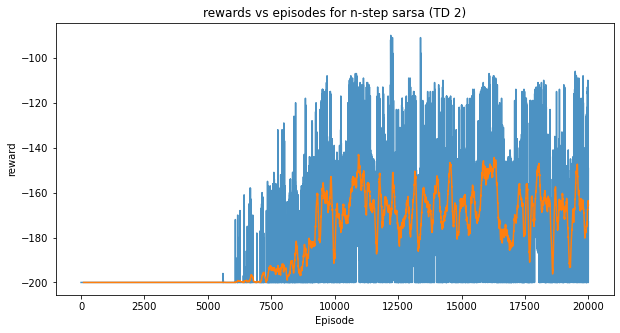

In [8]:
# plot rewards to assess the training performance
plt.figure(2, figsize=[10,5])
rewards = pd.Series(rewards_n_step_sarsa_2)
rm_r = rewards.rolling(100).mean()
plt.plot(rewards, alpha=0.8)
plt.plot(rm_r)
plt.xlabel('Episode')
plt.ylabel('reward')
plt.title('rewards vs episodes for n-step sarsa (TD 2)')
plt.show()

Average reward over 100 episodes: -170.03
number of successes (reward >= -199) in 100 episodes: 53


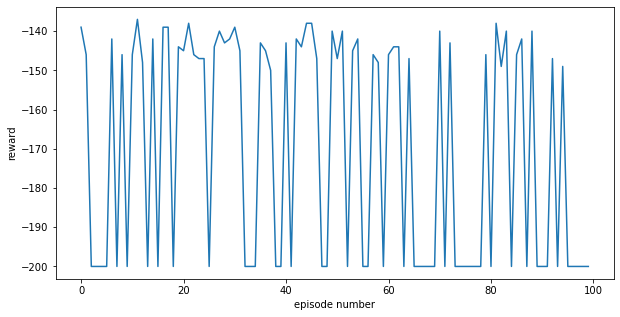

In [10]:
# test the learned policy
test(Q_n_step_sarsa_2, 0, 100)